In [320]:
import numpy as np
import pandas as pd
from mprod import table2tensor
from mprod.dimensionality_reduction import TCAM
from sklearn.decomposition import PCA
import seaborn as sn
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from skbio.stats.distance import permanova
from upsetplot import UpSet
from skbio.diversity import beta_diversity

Declare **functions** that will be used through the script

In [359]:
def Pseudocount(d):
    p = min(d[d>0]) / 1.5
    d2 = d + p
    return(d2)

def CLR_norm(x):
    d = np.array(x)
    d = Pseudocount(d)
    d = pd.DataFrame(d.astype(float), columns=list(x.columns))
    step1_1 = d.apply(np.log, axis = 0)
    step1_2 = step1_1.apply(np.average, axis = 1)
    step1_3 = step1_2.apply(np.exp)
    step2 = d.divide(step1_3, axis = 0)
    step3 = step2.apply(np.log, axis = 1)
    return(step3)
def TCA(DF):
    print("Create tensor")
    data_tensor, map1, map3 =  table2tensor(DF, missing_flag=True)
    print("Run TCA")
    tca = TCAM()
    tca_trans = tca.fit_transform(data_tensor)
    print("Generating result tables")
    tca_loadings = tca.mode2_loadings  # Obtain TCAM loadings
    tca_var = tca.explained_variance_ratio_*100 # % explained variation per TCA factor
    tca_df = pd.DataFrame(tca_trans)   # Cast TCA scores to dataframe
    tca_df.rename(index = dict(map(reversed, map1.items())) , inplace = True)    # use the inverse of map1 to denote each row 
                                   # of the TCAM scores with it's subject ID
    return(tca_trans, tca_loadings, tca_var, tca_df)
def Attach_columns(tca_df, Info, Column=["Type"] ):
    Column.append("NEXT_ID")
    To_add = Info[Column]
    To_add = To_add.drop_duplicates(keep='last')
    tca_df["NEXT_ID"] = list(tca_df.index)
    tca_df2 =tca_df.merge(To_add, on='NEXT_ID', how='left')
    return(tca_df2)

def Check_Loads(tca_loadings, Bugs, Top=15, Axis=0, Return=False, Plot=True):
    tca_loadings = pd.DataFrame(tca_loadings, index= Bugs)
    if Plot == False: return(tca_loadings)
    import matplotlib.pyplot as plt
    sn.kdeplot(data=tca_loadings, x=Axis)
    plt.show()
    plt.clf()
    #Biggest contributors to axis
    print(tca_loadings.sort_values(Axis).iloc[0:Top, Axis])
    print("====================================")
    print(tca_loadings.sort_values(Axis, ascending=False).iloc[0:Top,Axis])
    if Return== True:
        return(tca_loadings)

def Count_NA(x):
    x = x[x.notnull()]
    return(x.shape[0])    
def Quantify_Availability(Info, Recoded_time, Keep = [90] ):
    Info["Timepoint2"] =  Recoded_time
    Time_availability = Info.pivot(index='NEXT_ID', columns='Timepoint2', values='NG_ID')
    #Count total number of non-missing data
    Number_available = Time_availability.apply(Count_NA, axis=0)
    print(Number_available)
    
    #Filter according to keep
    Times_keep = Time_availability[Keep]
    Times_keep = Times_keep.dropna()
    
    Time_availability[ Time_availability.notnull() ] = True
    Time_availability[ Time_availability.isnull() ] = False
    
   
    
    #UpSet Plot
    Time_availability = Time_availability.reset_index()
    Time_availability.set_index( sorted(set(Recoded_time) ) , inplace=True)
    plt = UpSet(Time_availability, subset_size='count',  show_counts=True).plot()
    

    return(Times_keep)

def Cluster(tca_var, tca_df, N_components=2, N_clusters=2 ):
    import matplotlib.pyplot as plt
    print( "Total variability explained: " + str( round(tca_var[0:N_components].sum(), 2) ) + "%" )
    linkage_data = linkage(tca_df.iloc[:,0:N_components] , method='ward', metric='euclidean')
    dendrogram(linkage_data)
    plt.show()
    plt.clf()
    
    hierarchical_cluster = AgglomerativeClustering(n_clusters=N_clusters, affinity='euclidean', linkage='ward')
    labels = hierarchical_cluster.fit_predict(tca_df.iloc[:,0:N_components])
    
    tca_df["Cluster"] = list(labels)
    fig = sn.scatterplot(data=tca_df, x=0, y=1, hue="Cluster")
    fig.set(xlabel= 'Axis 1 ({Perc}%)'.format(Perc=round(tca_var[0],2)), ylabel='Axis 2 ({Perc}%)'.format(Perc=round(tca_var[1],2)) )
    plt.show()
    plt.clf()
    
    return(tca_df)

def Plot_abundances_vs_time(tca_df, Info, DF, Bugs_plot):
    import matplotlib.pyplot as plt
    To_merge = tca_df.reset_index(drop=False)
    To_merge = To_merge[["index", "Cluster"]]
    To_merge = To_merge.rename(columns={"index": "NEXT_ID"})
    Info_clusters =Info.merge(To_merge, on='NEXT_ID', how='left')
    Info_clusters = Info_clusters.dropna()
    DF["Cluster"] = list(Info_clusters["Cluster"])
    for Bug in Bugs_plot:
        Bug_abundance = DF[[Bug, "Cluster"]]
        Bug_abundance = Bug_abundance.reset_index(drop=False)
        Bug_short = Bug.split("|s__")[-1]
        fig = sn.boxplot(data=Bug_abundance, y=Bug, x="Timepoint", hue="Cluster", )
        #fig.map(sn.swarmplot, Bug, 'Timepoint')
        #fig.set_ylim( Bug_abundance[Bug].min() , Bug_abundance[Bug].max() )
        fig.set(ylabel=Bug_short + " (Clr)")
        fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        plt.clf()

def Do_permanova(Phenos, Pheno_list, tca_df,Perm=2000):
    Results_permanova = {}
    for Pheno in Pheno_list:
        To_add1 = Phenos[ ["baby_1_next_id", Pheno] ]
        To_add2 = Phenos[ ["baby_2_next_id", Pheno] ]
        To_add1 = To_add1.rename(columns = {"baby_1_next_id": "NEXT_ID"} )
        To_add2 = To_add2.rename(columns = {"baby_2_next_id": "NEXT_ID"})
        To_add  = pd.concat([To_add1, To_add2])
        To_add = To_add.dropna()
        To_add = To_add.astype({"NEXT_ID": int}, errors='raise') 
        To_add = To_add.astype({"NEXT_ID": str}, errors='raise') 

        To_add = To_add.set_index("NEXT_ID", drop=True)

        #Remove missing variables
        Not_Missing = []
        for i in list(tca_df_bb2.index):
            if i  in list(To_add.index): Not_Missing.append(i)   
        For_distance = tca_df.loc[ Not_Missing ]
        Distance = beta_diversity(metric = 'sqeuclidean', counts =For_distance, ids= For_distance.index)
   
        try:  
            Result = permanova(Distance, To_add, column=Pheno, permutations=Perm)
            P = Result["p-value"]
            Results_permanova[Pheno] = P
        except:
            Results_permanova[Pheno] = np.nan
    return(Results_permanova)

1. Read **microbiome data (DF)**   
2. **Sort** in the same ordet than **metadata (Info)**    
3. Keep only **species** level data  
4. **CLR**-normalization (with psuedocounting and including UNKNOWN proportion)  
5. Drop UNKNOWNS

In [3]:
#Read data, CLR-transform
Info = pd.read_csv("Data/final_metadata_NEXT_27_07_2022.txt", sep="\t")
DF = pd.read_csv("Data/NEXT_metaphlan_clean_11_07_2022.txt", sep="\t")
DF = DF[DF['ID'].isin(Info.NG_ID)]
#Order
DF.ID = DF.ID.astype("category")
DF.ID.cat.set_categories(Info.NG_ID, inplace=True)
DF = DF.sort_values(["ID"])

DF2 = DF.drop(["ID"], 1)
Keep_columns = [ "s__" in i for i in DF2.columns ]
Keep_columns[0] = True #"UNKNOWN"
DF2 = DF2.loc[:, Keep_columns]

DF2 = CLR_norm(DF2)
DF2 = DF2.drop("UNKNOWN", 1)

/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1181/3788182977.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  DF2 = DF.drop(["ID"], 1)
/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1181/3788182977.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  DF2 = DF2.drop("UNKNOWN", 1)


Data **formatting**   
We need the information of IDs (**NEXT_ID**) (same ID through time) and time (**Timepoint**) as multi-indexes   
Time points are reformatted to continuous numerics.  

In [4]:
# format and make into 3D tensor
Info2 = Info[["NEXT_ID", "Timepoint"]]
Dic_change = {'P12' : -180  , "P28" : -60 , "B" : 0 , "W2" : 14 ,  "M1" : 30, "M2" : 60, "M3" : 90 , "M6" : 180, "M9": 270, "M12" : 360 }
Recoded_time = []
[ Recoded_time.append(Dic_change[x]) for x in Info["Timepoint"] ]
Info2["Timepoint"] =  Recoded_time
DF3 = pd.concat([Info2.reset_index(drop=True), DF2.reset_index(drop=True)], axis=1)
#First two columns (ID and Timepoint need to become a multi-level index)
Arrays = [ list(DF3.NEXT_ID), list(DF3.Timepoint) ]
tuples = list(zip(*Arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["NEXT_ID", "Timepoint"])
DF3.index = index
DF3 =DF3.drop(["NEXT_ID", "Timepoint"], 1)


/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1181/2360421322.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Info2["Timepoint"] =  Recoded_time
/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1181/2360421322.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  DF3 =DF3.drop(["NEXT_ID", "Timepoint"], 1)


Use our function to:  
1. Go from a 2-D matrix, to a 3-D (**Tensor**) in which the third dimension represent matrices for the different time points
2. Decompose the Tensor and find the new axis that explain variability in the time patterns  
3. We get: Taxa loadings per each component (**tca_loadings**), Variability explained (%) per component (**tca_var**) and a data frame of components per individual (**tca_df**)

In [145]:
tca_trans, tca_loadings, tca_var, tca_df = TCA(DF3)

Create tensor
Run TCA
Generating result tables


Plotting complete dataset, including distinction mother/baby (**Info** column **Type**)

              0          1          2          3          4          5  \
0    -30.650746 -21.485604  -8.334130 -12.718607 -13.229822 -23.968824   
1    -27.249534 -18.664918  -7.982242  -8.375787 -12.366223 -21.709485   
2    -33.465488 -33.083852 -12.385767  27.347876  20.592405  -0.637904   
3    -25.733849 -24.418735  -9.734461  29.178233   5.517950  -4.705466   
4    -41.600719 -30.733805 -18.170137  -8.822320  -1.709669 -24.398786   
...         ...        ...        ...        ...        ...        ...   
1387   6.907051  -2.738270  22.603815  -5.275646   5.105200   8.383446   
1388   9.809373  -8.192382  22.517924  -9.409792   2.757376  14.748252   
1389   4.669431  -5.031563  12.021287  -3.940712   0.710898   7.005663   
1390   0.681686  -1.714039   4.694669   0.194368   1.381782   0.330830   
1391   6.941948  -6.000797   1.117010   3.985396   7.290743  -6.482441   

              6          7          8         9  ...          9141  \
0     -2.962143  -6.189009 -14.994533 -4.

<AxesSubplot:xlabel='0', ylabel='1'>

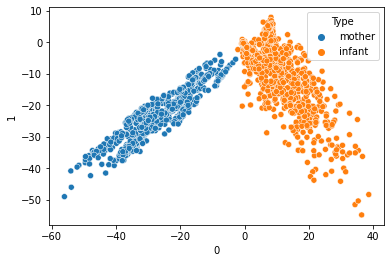

In [150]:
tca_df2 = Attach_columns(tca_df, Info, Column=["Type"] )
sn.scatterplot(data=tca_df2, x=0, y=1, hue="Type")

As missing data might be imputed. Now we repeat the analysis only with babies, where there are no points previous to 0.

In [298]:
#Repeat the process just with infants, I think there might be an imputation for mothers anyhow
#DF3.index
Mothers = Info["Type"]=="mother"
Mothers = list(Info[ Mothers.values ]["NEXT_ID"])
DF_babies = DF3.drop( Mothers  , level='NEXT_ID')
tca_trans_bb, tca_loadings_bb, tca_var_bb, tca_df_bb = TCA(DF_babies)



Create tensor
Run TCA
Generating result tables


[Text(0.5, 0, 'Axis 1 (6.48%)'), Text(0, 0.5, 'Axis 2 (3.06%)')]

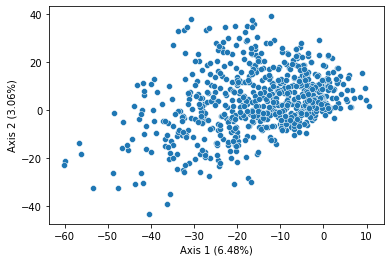

In [299]:
fig = sn.scatterplot(data=tca_df_bb, x=0, y=1)
fig.set(xlabel= 'Axis 1 ({Perc}%)'.format(Perc=round(tca_var_bb[0],2)), ylabel='Axis 2 ({Perc}%)'.format(Perc=round(tca_var_bb[1],2)) )


We check which taxa are important for the axis that explained most variability (1 and 2)

[6.48449056e+00 3.06470996e+00 1.33671200e+00 ... 3.97199126e-33
 2.43276266e-33 2.43276266e-33]

Exploring Axis 1 loads

k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum         -0.353859
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli               -0.288483
k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens              -0.254172
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_breve          -0.253673
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum        -0.242714
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides

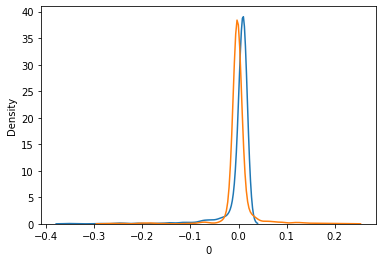

In [41]:
print(tca_var_bb)

print("\nExploring Axis 1 loads\n")

Loads = Check_Loads(tca_loadings = tca_loadings_bb, Bugs = list(DF_babies.columns), Top=15, Axis=0, Return=True)

print("\nExploring Axis 2 loads\n")

Check_Loads(tca_loadings = tca_loadings_bb, Bugs = list(DF_babies.columns), Top=15, Axis=1, Return=False)


We group samples according to their components into clusters, so that we can compare their trends in individual taxa.

Total variability explained: 9.55%


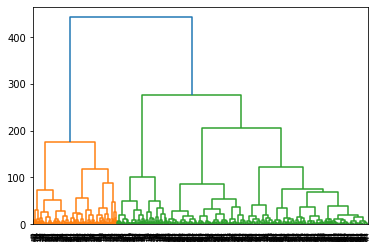

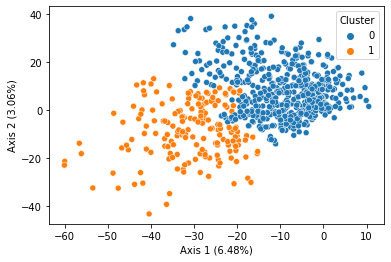

<Figure size 432x288 with 0 Axes>

In [300]:
tca_df_bb = Cluster(tca_var_bb, tca_df_bb, N_components=2, N_clusters=2 )

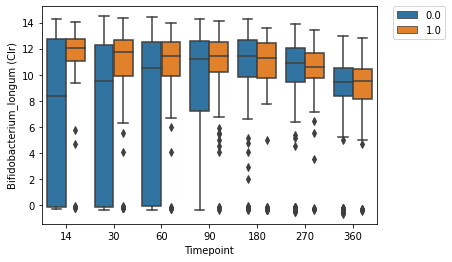

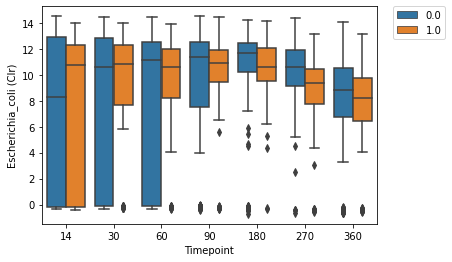

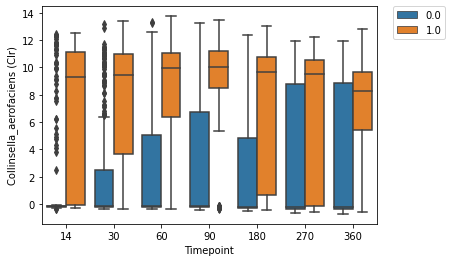

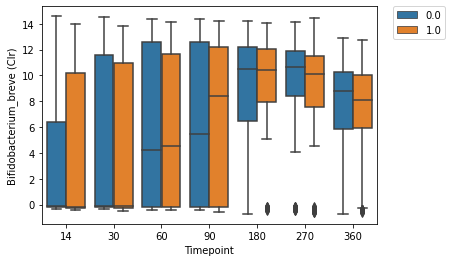

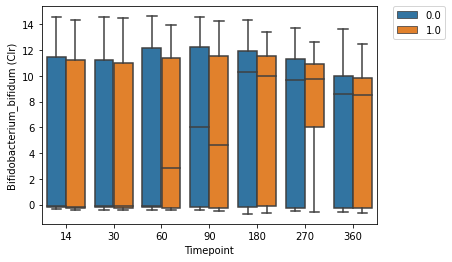

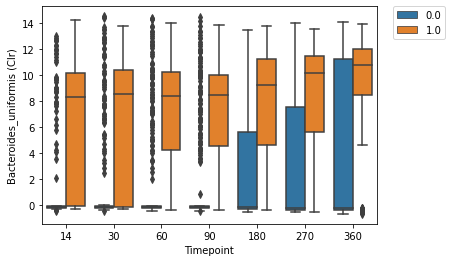

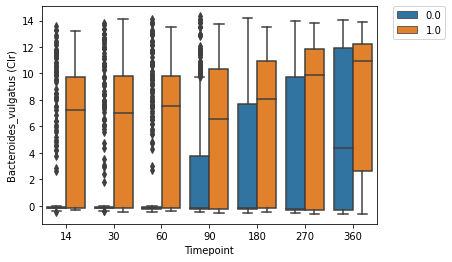

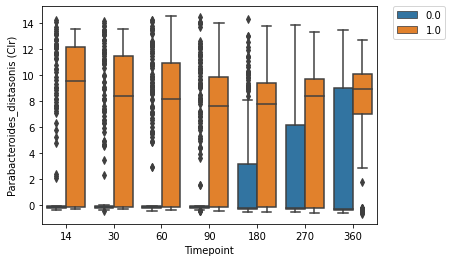

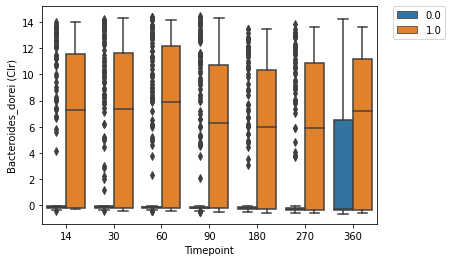

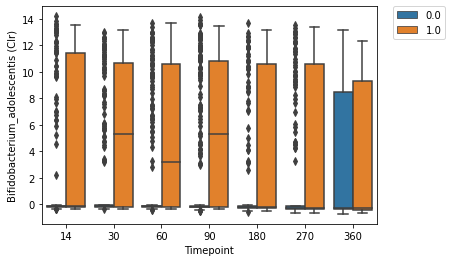

<Figure size 432x288 with 0 Axes>

In [306]:
if "Cluster" in list(DF_babies.columns):
    DF_babies = DF_babies.drop("Cluster", axis=1)
Loads = Check_Loads(tca_loadings = tca_loadings_bb, Bugs = list(DF_babies.columns), Top=15, Axis=0, Return=True, Plot=False)
Bugs_plot = Loads.sort_values(0, ascending=True).iloc[0:10, 0]
Bugs_plot = list(Bugs_plot.index)
Plot_abundances_vs_time(tca_df_bb, Info, DF_babies, Bugs_plot)




The approach is imputing the missing values. I will check if running complete samples only, and different convinations of timepoints find the same. Also, making the plot interactive will show us whether the points we find close are the same.

Create tensor
Run TCA
Generating result tables


[Text(0.5, 0, 'Axis 1 (6.04%)'), Text(0, 0.5, 'Axis 2 (2.4%)')]

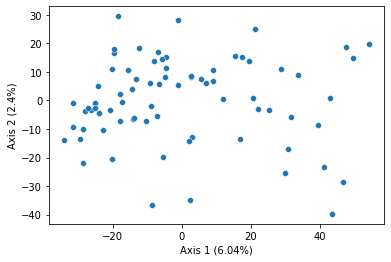

In [307]:
Grouped = Info.groupby("NEXT_ID")
Grouped = Grouped.count()
Complete = Grouped.loc[ Grouped["NG_ID"] == 7  ]
DF_complete =  DF3.loc[ list(Info["NEXT_ID"].isin(list(Complete.index)))]
tca_trans_com, tca_loadings_com, tca_var_com, tca_df_com = TCA(DF_complete)
fig = sn.scatterplot(data=tca_df_com, x=0, y=1)
fig.set(xlabel= 'Axis 1 ({Perc}%)'.format(Perc=round(tca_var_com[0],2)), ylabel='Axis 2 ({Perc}%)'.format(Perc=round(tca_var_com[1],2)) )


Exploring Axis 1 loads



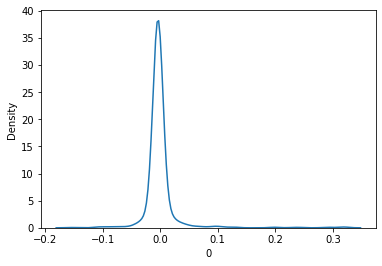

k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula                      -0.155045
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_dentium   -0.111191
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_atypica                      -0.106438
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_mitis                        -0.101715
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parainfluenzae     -0.094793
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_dispar                       -0.089019
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_p

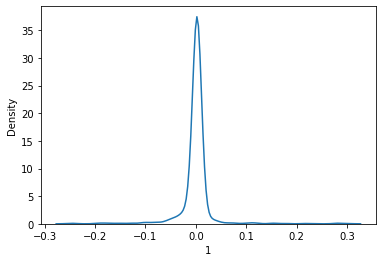

k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_distasonis                 -0.252048
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus                           -0.241108
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_dentium        -0.196948
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_ovatus                             -0.187573
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_adolescentis   -0.182545
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parainfluenzae          -0.172327
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellac

<Figure size 432x288 with 0 Axes>

In [309]:
print("\nExploring Axis 1 loads\n")
Loads_complete = Check_Loads(tca_loadings = tca_loadings_com, Bugs = list(DF_complete.columns), Top=15, Axis=0, Return=True)
print("\nExploring Axis 2 loads\n")
Check_Loads(tca_loadings = tca_loadings_com, Bugs = list(DF_complete.columns), Top=15, Axis=1, Return=False)


In [310]:
print(Loads.shape, Loads_complete.shape)
Comparison = {}
for x in range(0,10):
    for y in range(0,10):
        Comparison[ str(x)+"-"+str(y) ] = []
        R = pearsonr(Loads.iloc[:,x], Loads_complete.iloc[:,y])
        Comparison[ str(x)+"-"+str(y) ].extend([R[0], R[1]])
Comparison = pd.DataFrame(Comparison, index=["Rho", "P"]).transpose()
Comparison = Comparison.sort_values("P")
pd.set_option("display.max_rows", None, "display.max_columns", None)

print(Comparison)

(915, 5011) (915, 524)
          Rho              P
7-0 -0.853228  2.357176e-260
1-0 -0.790651  1.001631e-196
8-4  0.774513  8.639895e-184
2-1 -0.631790  4.209569e-103
3-0 -0.610867   1.090113e-94
6-3 -0.595724   5.549377e-89
0-0 -0.547255   1.301592e-72
5-1  0.519733   1.897962e-64
6-2 -0.498968   9.119458e-59
4-0 -0.493792   2.070733e-57
5-3 -0.461110   2.309907e-49
5-2  0.446533   4.798931e-46
9-2  0.440810   8.714797e-45
0-2  0.404949   2.007936e-37
2-2  0.388330   2.647445e-34
9-7  0.388188   2.809681e-34
4-2  0.383230   2.212823e-33
3-2  0.362389   8.861797e-30
2-6  0.346171   3.737186e-27
1-2 -0.310732   6.225906e-22
4-7  0.301932   9.682213e-21
6-9 -0.270870   7.510783e-17
2-8  0.269555   1.070840e-16
8-3  0.268586   1.388816e-16
0-7  0.267722   1.750070e-16
9-9 -0.229870   1.946068e-12
9-8 -0.229496   2.117312e-12
9-6 -0.224380   6.616537e-12
2-3 -0.217901   2.692152e-11
6-4  0.216218   3.849398e-11
1-7 -0.209751   1.479392e-10
8-7 -0.192053   4.739497e-09
5-7 -0.186789   1.25

Now, we will check which samples have different time points available, and use three time points available for the maximum number of available samples to explore trend patterns

Timepoint2
-180     394
-60      379
 0       253
 14      330
 30      445
 60      470
 90     1000
 180     347
 270     343
 360     409
dtype: int64


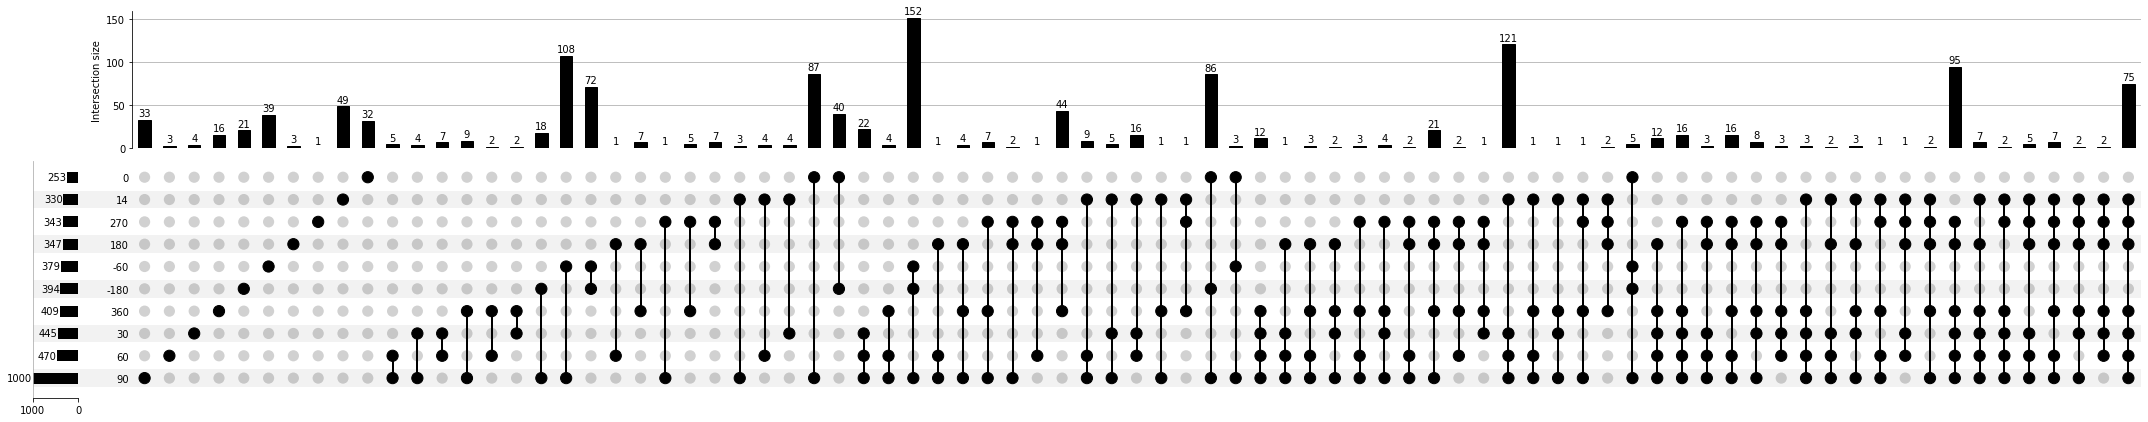

In [311]:
#Check samples with first and last time point available
All_keep =  Quantify_Availability(Info, Recoded_time)

/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1181/1231371066.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Info["Timepoint2"] =  Recoded_time


Timepoint2
-180    394
-60     379
 0      253
 90     472
dtype: int64


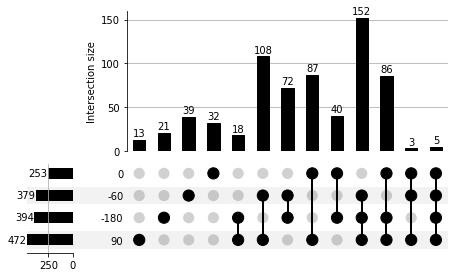

In [312]:
Info_mothers = Info[Info["Type"]=="mother"]
Recoded_time_mothers = []
[ Recoded_time_mothers.append(Dic_change[x]) for x in Info_mothers["Timepoint"] ]
Mother_keep = Quantify_Availability(Info_mothers, Recoded_time_mothers, [-180, -60 , 90])

/var/folders/nf/9wry_8qs6gl5r51wp8466mvm0000gn/T/ipykernel_1181/1231371066.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Info["Timepoint2"] =  Recoded_time


Timepoint2
14     330
30     445
60     470
90     528
180    347
270    343
360    409
dtype: int64


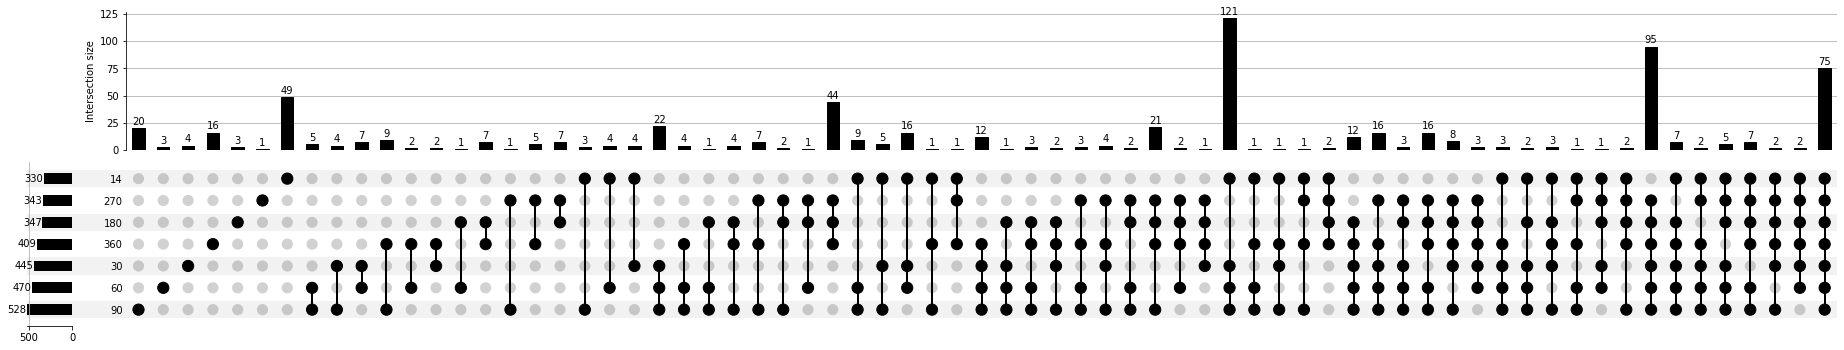

In [313]:
Info_infants = Info[Info["Type"]!="mother"]
Recoded_time_infants = []
[ Recoded_time_infants.append(Dic_change[x]) for x in Info_infants["Timepoint"] ]
Baby_keep = Quantify_Availability(Info_infants, Recoded_time_infants, [30, 90 , 270])

Perform analysis in baby time point 30, 90, 270, only with complete samples

In [353]:
Info_babies_selection = Info[Info["NEXT_ID"].isin( list(Baby_keep.index) )]
Info_babies_selection2 = Info_babies_selection[ Info_babies_selection["Timepoint2"].isin([30, 90 , 270]) ]
DF_babies2 = DF3.query('NEXT_ID in list(@Info_babies_selection["NEXT_ID"]) ')
DF_babies2 = DF_babies2[ list(Info_babies_selection["Timepoint2"].isin([30, 90 , 270])) ]
tca_trans_bb2, tca_loadings_bb2, tca_var_bb2, tca_df_bb2 = TCA(DF_babies2)

Create tensor
Run TCA
Generating result tables


Total variability explained: 22.7%


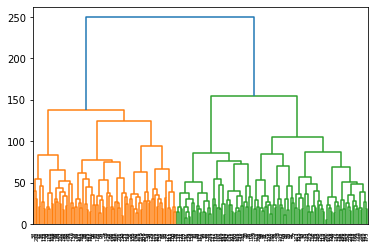

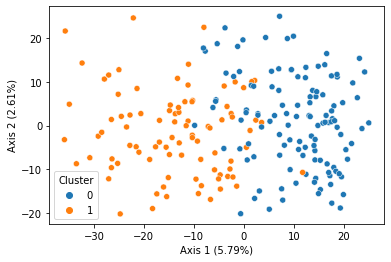

<Figure size 432x288 with 0 Axes>

In [315]:
tca_df_bb2 = Cluster(tca_var_bb2, tca_df_bb2, N_components=10, N_clusters=2 )

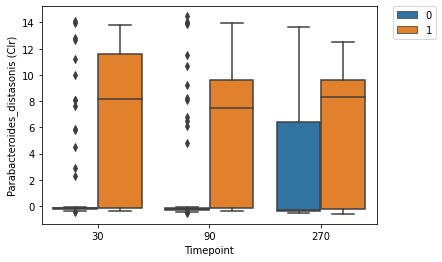

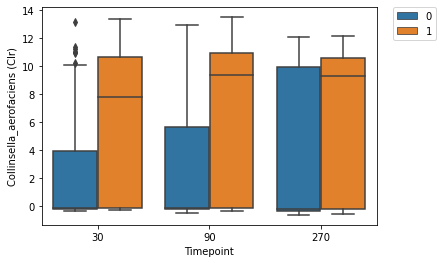

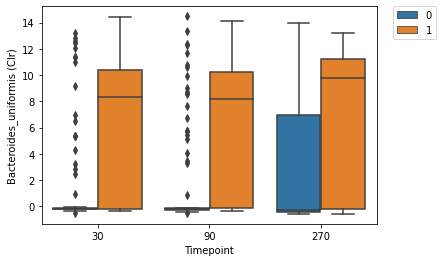

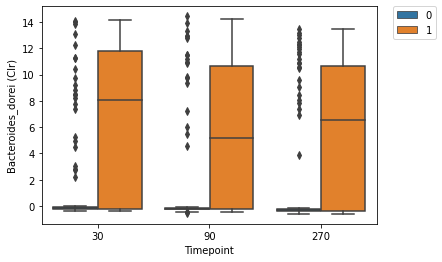

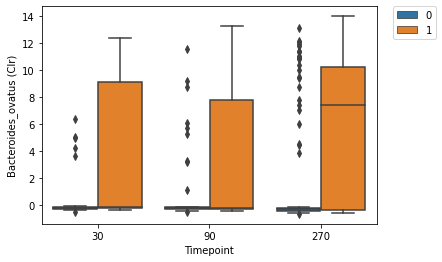

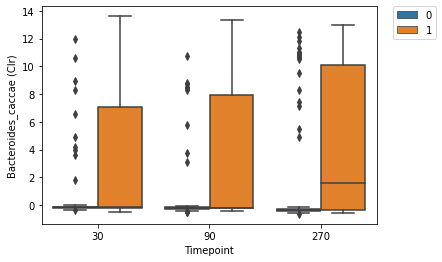

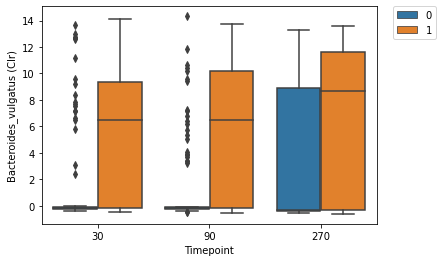

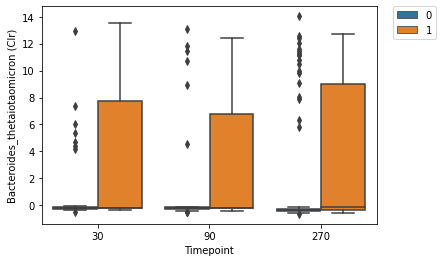

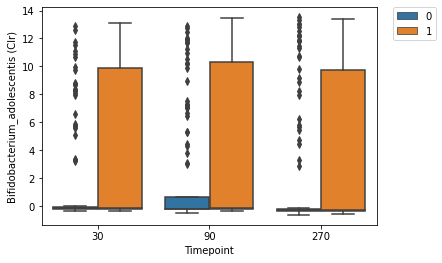

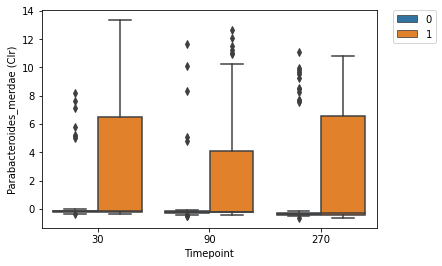


============Bugs Axis 2=========



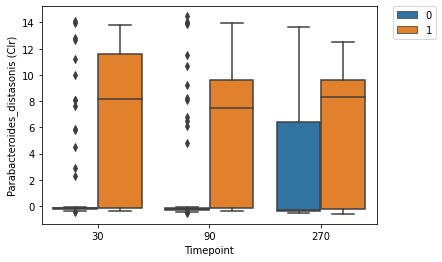

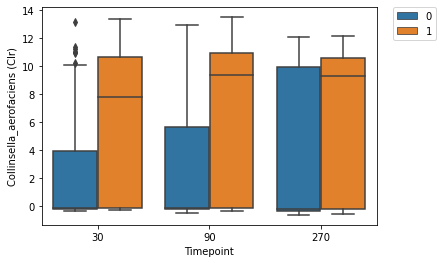

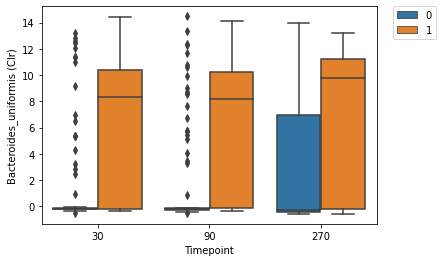

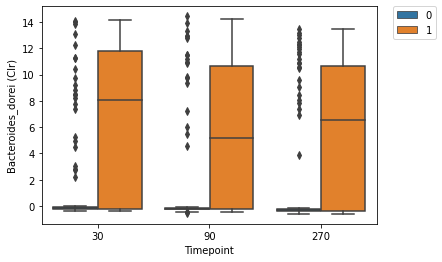

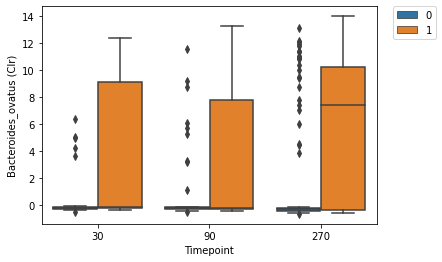

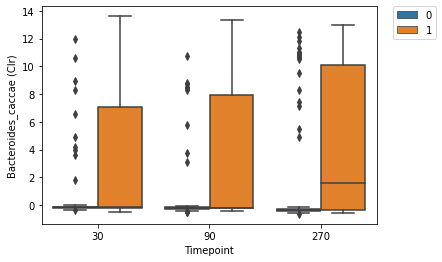

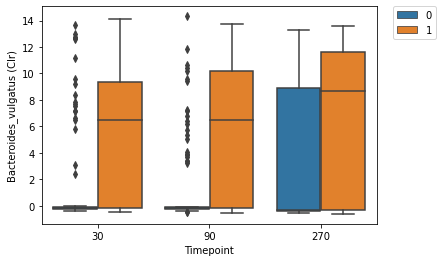

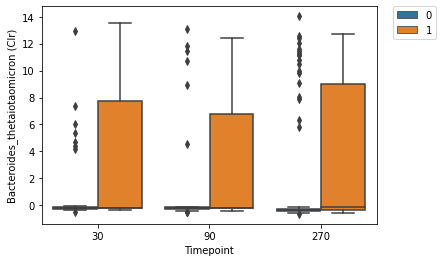

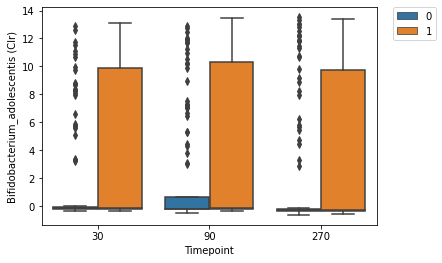

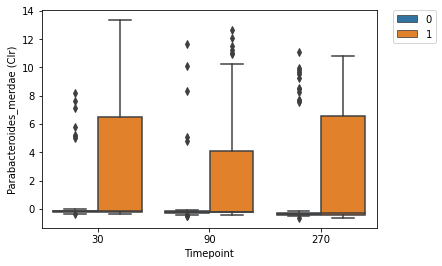

<Figure size 432x288 with 0 Axes>

In [316]:
if "Cluster" in list(DF_babies2.columns):
    DF_babies2 = DF_babies2.drop("Cluster", axis=1)

Loads = Check_Loads(tca_loadings = tca_loadings_bb2, Bugs = list(DF_babies2.columns), Top=15, Axis=0, Return=True, Plot=False)
Bugs_plot = Loads.sort_values(0, ascending=True).iloc[0:10, 0]
Bugs_plot = list(Bugs_plot.index)
Plot_abundances_vs_time(tca_df_bb2, Info_babies_selection2, DF_babies2, Bugs_plot)

print("\n============Bugs Axis 2=========\n")

#Do the same with axis 2
Bugs_plot = Loads.sort_values(0, ascending=True).iloc[0:10, 1]
Bugs_plot = list(Bugs_plot.index)
Plot_abundances_vs_time(tca_df_bb2, Info_babies_selection2, DF_babies2, Bugs_plot)



Repeat analysis in mother samples with time points -180, -60 and 90 available

(157, 3)
Create tensor
Run TCA
Generating result tables
Total variability explained: 25.6%


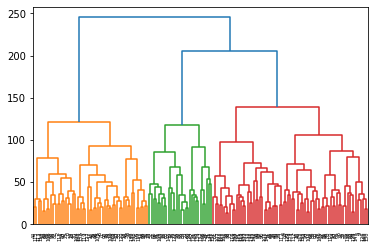

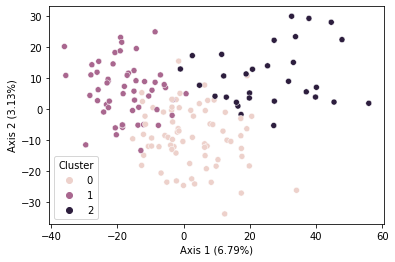

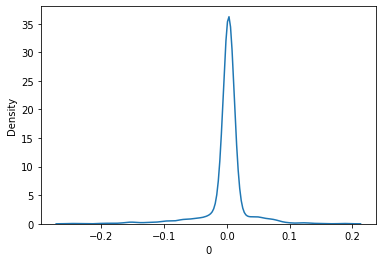

k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_copri                                                        -0.246464
k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_110   -0.198525
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_xylaniphila                                          -0.187815
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_57_20                                                 -0.174339
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_merdae                                             -0.160790
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_unclassified|s_

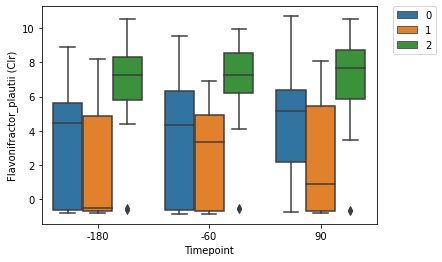

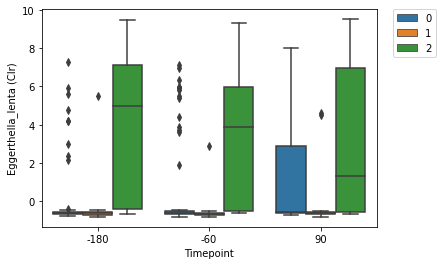

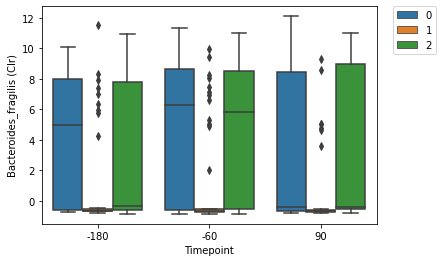

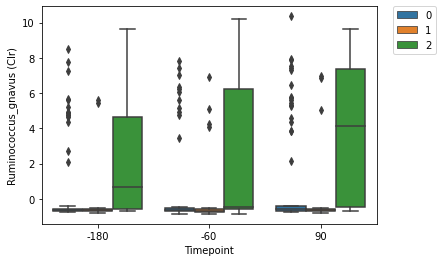

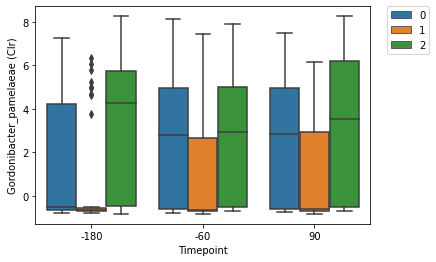

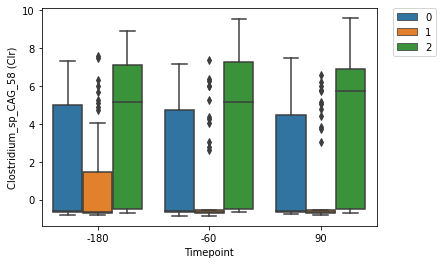

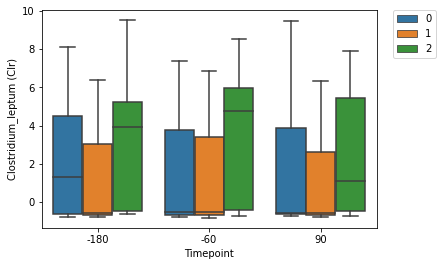

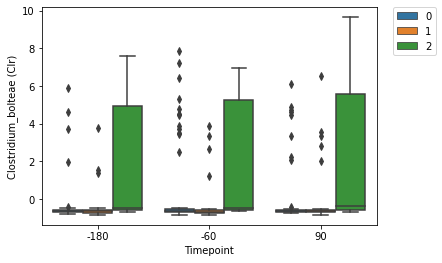

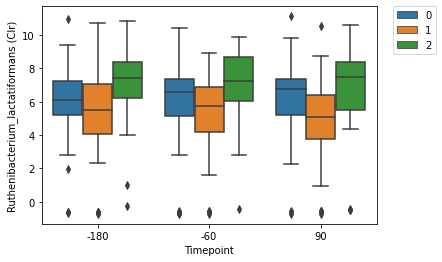

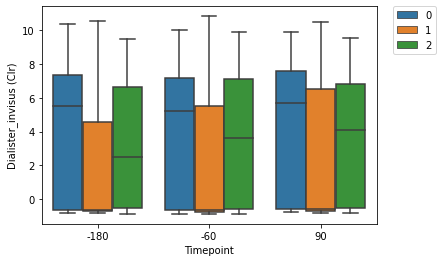

<Figure size 432x288 with 0 Axes>

In [365]:
#Mother analysis in three time points
print(Mother_keep.shape)
Info_mothers_selection = Info[Info["NEXT_ID"].isin( list(Mother_keep.index) )]
Info_mothers_selection2 = Info_mothers_selection[ Info_mothers_selection["Timepoint2"].isin([-180, -60 , 90]) ]
DF_mothers = DF3.query('NEXT_ID in list(@Info_mothers_selection["NEXT_ID"]) ')
DF_mothers = DF_mothers[ list(Info_mothers_selection["Timepoint2"].isin([-180, -60 , 90])) ]


#Run
tca_trans_m, tca_loadings_m, tca_var_m, tca_df_m = TCA(DF_mothers)
#Cluster
tca_df_m2 = Cluster(tca_var_m, tca_df_m, N_components=10, N_clusters=3 )
#Loads
Loads = Check_Loads(tca_loadings = tca_loadings_m, Bugs = list(DF_mothers.columns), Top=15, Axis=0, Return=True)
#Bug plot
Bugs_plot = Loads.sort_values(0, ascending=False).iloc[0:10, 0]
Bugs_plot = list(Bugs_plot.index)
Plot_abundances_vs_time(tca_df_m2, Info_mothers_selection2, DF_mothers, Bugs_plot)




Finally, we used **PERMANOVA** on a distance matrix based on the new axes(we can perform dimensionality reduction first) to find which phenotypes are related with different temporal patterns in babies

In [360]:
#Permanova using the Matrix of values

Phenos = pd.read_csv("Data/mothers_infant_birth_combined_phenotypes_birthcards.txt", sep="\t")

Pheno_list= []
for i in list(Phenos.columns):
    if i not in ["next_id_mother", "baby_1_next_id", "baby_2_next_id" ]:
        if "baby_" in i: continue
        Pheno_list.append(i)
        
Perm_results = Do_permanova(Phenos, Pheno_list, tca_df_bb2, Perm = 15000)

#format results
Perm_results = pd.DataFrame(Perm_results, index=["Pvalue"] ).transpose()
Perm_results = Perm_results.sort_values("Pvalue")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(Perm_results)


                                                      Pvalue
age_years_m1                                        0.000067
age_years_p12                                       0.000067
duration_broken_water_cont_numeric_hours            0.000067
duration_broken_water_cont_numeric_min              0.000067
del_mode_complex                                    0.000133
del_mode_simple                                     0.000200
mother_medication_during_birth                      0.000533
mother_med_anaesthetic_opioid_N01AH_during_birt...  0.000667
mother_preg_comp_GDM_all                            0.001333
mother_age                                          0.002733
del_labor_pain_relief                               0.002866
gestational_age_numeric_weeks                       0.004400
gestational_age_numeric_days                        0.005133
place_delivery_BC                                   0.005666
del_labor_IV_contraction_inducers                   0.005933
mother_med_antibiotics_c